In [2]:
import matplotlib.pyplot as plt
import numpy as np
from commpy.modulation import QAMModem

# Modulos do OptiCommpy
from pyfiles.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from pyfiles.models import phaseNoise, KramersKronigRx, linFiberCh
from pyfiles.tx import simpleWDMTx
from pyfiles.core import parameters
from pyfiles.equalization import edc, mimoAdaptEqualizer
from pyfiles.carrierRecovery import cpr
from pyfiles.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from pyfiles.plot import pconst

import scipy.constants as const
# Modulo responsável pelo pre-processamento, criação de datasets, treinamento e criação de modelos. 
from pyfiles.functions import ANN_model

### Simulação de uma transmissão de sinal óptico de polarização única

In [3]:
## Parâmetros do Transmissor:

paramTx = parameters()
paramTx.M = 16                 # ordem do formato de modulação
paramTx.Rs = 32e9              # taxa de símbolo [baud]
paramTx.SpS = 4                # amostras por símbolo
paramTx.Nbits = 400000         # número total de bits por polarização
paramTx.pulse = "rrc"          # filtro de modelagem de pulso
paramTx.Ntaps = 1024           # número de coeficientes de filtro de modelagem de pulso
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # potência do sinal óptico [dBm]
paramTx.Nch = 1                # número de canais WDM
paramTx.Fc = 193.1e12          # frequência central do espectro óptico
paramTx.freqSpac = 37.5e9      # espaçamento da grade WDM

## Parâmetros do canal óptico:

Ltotal = 55      # distância total do link [km]
alpha = 0        # parâmetro de perda da fibra [dB/km]
D = 16           # parâmetro de disperção [ps/nm/km]
Fc = paramTx.Fc  # frequência óptica central do espectro WDM [Hz]

## Parâmetros do receptor:

# local oscillator (LO) - Alterar a frequência do sinal.
FO = paramTx.Rs/2   # deslocamento de frequência
lw = 0*200e3        # espessura da linha
ϕ_lo = 0            # fase inicial em rad
Plo_dBm = 12        # potência em dBm

# Taxa de amostragem ADC
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 2

## Parâmetros gerais de simulação:

chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

### Script de simulação do núcleo

In [27]:
# gera o sinal óptico
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simula a propagação de sinal linear na fibra
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)
# adiciona as disperções em 25, 35 e 55 [km]
#sigCh_0 = linFiberCh(sigTx, 25, alpha, D, Fc, Fs)
#sigCh_1 = linFiberCh(sigTx, 35, alpha, D, Fc, Fs)
#sigCh_2 = linFiberCh(sigTx, 55, alpha, D, Fc, Fs)

# detecção e demodulação do receptor
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# gera o campo LO para sigCh
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)
sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
# Adiciona LO ao sinal recebido
sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm = sigRx.copy()
print('L: null CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# gera o campo LO para sigCh_0
π = np.pi
t = np.arange(0, len(sigCh_0))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_0), Ts)
sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
# Adiciona LO ao sinal recebido
sigRx = np.sqrt(Plo) + sigCh_0 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_0 = sigRx.copy()
print('L: 25Km CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh_0))))

# gera o campo LO para sigCh_1
π = np.pi
t = np.arange(0, len(sigCh_1))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_1), Ts)
sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
# Adiciona LO ao sinal recebido
sigRx = np.sqrt(Plo) + sigCh_1 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_1 = sigRx.copy()
print('L: 35Km CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh_1))))

# gera o campo LO para sigCh_2
π = np.pi
t = np.arange(0, len(sigCh_2))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh_2), Ts)
sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
# Adiciona LO ao sinal recebido
sigRx = np.sqrt(Plo) + sigCh_2 * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm_2 = sigRx.copy()
print('L: 55Km CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh_2))))

# reamostragem para taxa de amostragem ADC
sigCh = resample(sigCh, paramADC)
sigCh_0 = resample(sigCh_0, paramADC)
sigCh_1 = resample(sigCh_1, paramADC)
sigCh_2 = resample(sigCh_2, paramADC)
sigCht = np.concatenate((sigCh, sigCh_0, sigCh_1, sigCh_2))

sfm = resample(sfm, paramADC)
sfm_0 = resample(sfm_0, paramADC)
sfm_1 = resample(sfm_1, paramADC)
sfm_2 = resample(sfm_2, paramADC)
sfmt = np.concatenate((sfm, sfm_0, sfm_1, sfm_2)) 

newFs = paramADC.SpS_out*paramTx.Rs


channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz
L: null CSPR = 12.00 dB
L: 25Km CSPR = 12.00 dB
L: 35Km CSPR = 12.00 dB
L: 55Km CSPR = 12.00 dB


### Simulação do receptor óptico de detecção direta ideal

In [17]:
# Captura a intensidade do sinal transmitido em todas as disperções
Amp = np.abs(sfmt)
Amp = resample(Amp, paramADC)
sfmt = sfm/np.sqrt(signal_power(sfmt))

# Número de amostras de amplitude de entrada para o NN
N = 256

# Obtem amostras de Amplitude e Fase do sinal

# Amostras de fase
sigPhase = np.angle(sfmt)
# Amostras de amplitude
sigAmp = np.pad(np.abs(sfmt), (int(N/2), int(N/2)), 'constant')

### Estágio de recuperação de fase

In [18]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

Epoch 1/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0401 - val_loss: 0.0144
Epoch 2/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 3/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
547/547 [==============================] - 1s 1ms/step - loss: 0.0011 - val_lo

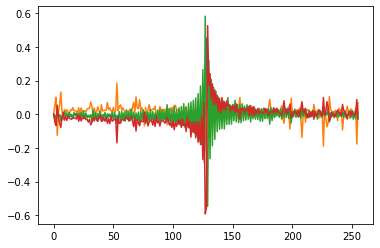

In [19]:
# Cria o dataset para o treinamento
x_train = np.zeros((len(sigPhase), N))

for index in range(len(sigPhase)):
    x_train[index] = sigAmp[index:N+index]

# Conjunto de rótulos de fase
y_train = sigPhase.copy()

# define neural network model
stop = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(N,)))
model.add(Dense(8, activation='relu'))
# model.add(Dense(8,activation='gelu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=100, callbacks=[stop], validation_split=0.3, batch_size=256)

model.summary()

cw1 = model.layers[1].get_weights()
plt.plot(cw1[0])


In [20]:
phiTime_NN = model.predict(x_train)
phiTime_NN = phiTime_NN.reshape(-1,)

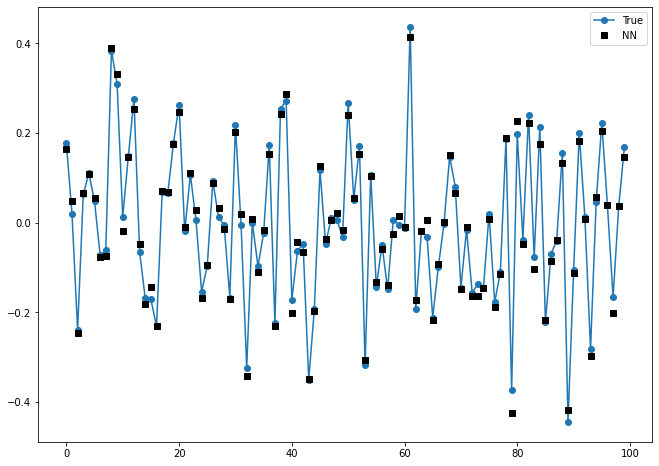

In [26]:
plt.figure(figsize=(11, 8))
plt.plot(np.angle(sfmt)[300:400], '-o', label='True')
plt.plot(phiTime_NN[300:400], 's', label='NN', color='black')
plt.legend()